## Mount Google Drive to access your data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Ultrasound_project/'

In [ ]:
import random

In [ ]:
random.seed(13204942)

## Model Definition

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

<figure>
<center>
<img src='https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png' width="800" height="500"/>
<figcaption>Image Caption</figcaption></center>
</figure>

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),  # bias = false because using batchnorm2d
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),  # bias = false because using batchnorm2d
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv(x)


In [ ]:
class UNET(nn.Module):
  def __init__(self,
               in_channels=3,
               out_channels=1,
               features=[64, 128, 256, 512],
               ):
    super(UNET, self).__init__()
    self.encoders = nn.ModuleList()
    self.decoders = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Encoder part of UNet
    for feature in features:
      self.encoders.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Decoder part of UNet
    for feature in reversed(features):
      self.decoders.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2
          )
      )
      self.decoders.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for encoder in self.encoders:
      x = encoder(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.decoders), 2):
      x = self.decoders[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.decoders[idx+1](concat_skip)

    return self.final_conv(x)


In [ ]:
# calculate total parameters of the model
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def test():
  x = torch.randn((1, 1, 540, 540))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

In [ ]:
model = UNET(in_channels=3, out_channels=1)
print(model)

UNET(
  (encoders): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplac

In [ ]:
para_count = count_parameters(model)
print (f"{para_count:,}")

31,037,633


In [ ]:
para_count = count_parameters(model.decoders)
print (f"{para_count:,}")

12,190,400


In [ ]:
test()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 1, 540, 540])
torch.Size([1, 1, 540, 540])


## Dataset

In [ ]:
import os
import cv2
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import glob

In [ ]:
#TRAIN_IMG_DIR = root_path + "HC18_UNet/train_images/"
#TRAIN_MASK_DIR = root_path + "HC18_UNet/train_masks/"
#VAL_IMG_DIR = root_path + "HC18_UNet/val_images/"
#VAL_MASK_DIR = root_path + "HC18_UNet/val_masks/"

TRAIN_IMG_DIR = root_path + "HC18_UNet_orig/train_images/"
TRAIN_MASK_DIR = root_path + "HC18_UNet_orig/train_masks/"
VAL_IMG_DIR = root_path + "HC18_UNet_orig/val_images/"
VAL_MASK_DIR = root_path + "HC18_UNet_orig/val_masks/"

TRAIN_ORIG_MASK_DIR = root_path + "HC18_UNet_orig/train_orig_masks/"
VAL_ORIG_MASK_DIR = root_path + "HC18_UNet_orig/val_orig_masks/"

Below functon **fill_contour_region** <font color='red'>ONLY</font> needs to be executed once.

In [ ]:
def fill_contour_region(path, save_path):
  #mask = np.array(Image.open(path).convert("L"))
  img = cv2.imread(path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  #contours = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #contours = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  #contours = contours[0] if len(contours) == 2 else contours[1]
  #contours = contours[-2] # for cv2 v3 and v4+ compatibility
  for contour in contours:
    convexHull = cv2.convexHull(contour)
    cv2.drawContours(img_gray, [convexHull], contourIdx=-1, color=(255,255,255), thickness=-1)

  #for c in contours:
  #    cv2.drawContours(img_gray, [c], -1, (255,255,255), -1)

  #cv2.drawContours(img_gray, contours, contourIdx=-1, color=(255,255,255), thickness=-1)

  #return np.array(img_gray, dtype=np.float32)
  #return img_gray
  cv2.imwrite(save_path, img_gray)

Fill out the contour on each mask image.

In [ ]:
'''
for file in glob.glob(TRAIN_ORIG_MASK_DIR + "*.*"):
  filename = file[file.rfind('/')+1:]
  save_path = TRAIN_MASK_DIR + filename

  fill_contour_region(file, save_path)
'''

'\nfor file in glob.glob(TRAIN_ORIG_MASK_DIR + "*.*"):\n  filename = file[file.rfind(\'/\')+1:]\n  save_path = TRAIN_MASK_DIR + filename\n\n  fill_contour_region(file, save_path)\n'

In [ ]:
'''
for file in glob.glob(VAL_ORIG_MASK_DIR + "*.*"):
  filename = file[file.rfind('/')+1:]
  save_path = VAL_MASK_DIR + filename

  fill_contour_region(file, save_path)
'''

'\nfor file in glob.glob(VAL_ORIG_MASK_DIR + "*.*"):\n  filename = file[file.rfind(\'/\')+1:]\n  save_path = VAL_MASK_DIR + filename\n\n  fill_contour_region(file, save_path)\n'

In [ ]:
#path = '/content/drive/MyDrive/HC18_UNet_orig/val_orig_masks/787_HC_Annotation.png'
path = f'{root_path}HC18_UNet_orig/val_masks/785_HC_Annotation.png'
img = cv2.imread(path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#contours = contours[-2]
#thresh = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY)[1]
#contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#contours = contours[0] if len(contours) == 2 else contours[1]
#cv2.drawContours(img_gray, [max(contours, key = cv2.contourArea)], contourIdx=-1, color=(255,255,255), thickness=-1)
#cv2.drawContours(img_gray, contours, contourIdx=0, color=(255,255,255), thickness=-1)

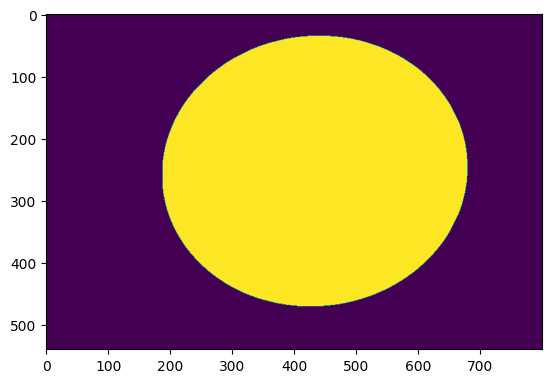

In [ ]:
plt.imshow(img_gray)

In [ ]:
class HeadDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace(".png", "_Annotation.png"))
    #mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
    image = np.array(Image.open(img_path).convert("RGB"))
    #mask = fill_contour_region(mask_path)
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
    # we need to use sigmoid
    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = HeadDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = HeadDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

### Load Saved Dataset



In [ ]:
save_path = root_path + 'train_data_split/'

In [ ]:
#save_path + 'split_train_size_10.pt'
#save_path + 'split_train_size_30.pt'
save_path + 'split_train_size_50.pt'

'/content/drive/MyDrive/Ultrasound_project/train_data_split/split_train_size_50.pt'

In [ ]:
#train_ds = torch.load(save_path + 'split_train_size_10.pt')
#train_ds = torch.load(save_path + 'split_train_size_30.pt')
train_ds = torch.load(save_path + 'split_train_size_50.pt')

print(f'The lenght of train dataset: {len(train_ds)}')

The lenght of train dataset: 399


### Start DataLoader

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
torch.manual_seed(13204942)

In [ ]:
BATCH_SIZE = 10
NUM_WORKERS = 2
PIN_MEMORY = True

IMAGE_HEIGHT = 512  # 540 originally
IMAGE_WIDTH = 512  # 800 originally

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=25, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [ ]:
# split train, validation
full_dataset = HeadDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
    )

In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

In [ ]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
print(len(train_loader))
print(len(val_loader))

40
20


In [ ]:
ckpt_name = root_path + "Saved_models/my_Unet_baseline_50per.pth.tar"
model_name = root_path + "Saved_models/my_Unet_baseline_50per.pth"

## Train Model

In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

In [ ]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 20
LOAD_MODEL = False

In [ ]:
def save_checkpoint(state, filename="/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def save_model(model, filename="/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline.pth"):
    print("=> Saving model")
    torch.save(model, filename)
    print('Model saved!')

In [ ]:
def check_accuracy(loader, model, loss_fn, device="cuda", is_training = True):
    num_correct = 0
    num_pixels = 0
    dice_score = 0.0
    iou = 0.0
    losses = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            prediction = model(x)

            loss = loss_fn(prediction, y.float())
            losses.append(loss.item())

            preds = torch.sigmoid(prediction)
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
                )
            iou += (preds * y).sum() / (
                (preds + y).sum() - (preds * y).sum() + 1e-8
                )

    print(f"Got validation loss: {np.mean(losses):.6f}")
    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score / len(loader)}")
    print(f"mIoU: {iou / len(loader)}")

    if is_training:
      model.train()

In [ ]:
def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda", is_training = True):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    if is_training:
      model.train()

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

  return loss.item()

In [ ]:
'''
train_loader, _ = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
    )
'''

'\ntrain_loader, _ = get_loaders(\n    TRAIN_IMG_DIR,\n    TRAIN_MASK_DIR,\n    VAL_IMG_DIR,\n    VAL_MASK_DIR,\n    BATCH_SIZE,\n    train_transform,\n    val_transforms,\n    NUM_WORKERS,\n    PIN_MEMORY,\n    )\n'

In [ ]:
'''
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)
'''

'\ntrain_loader = DataLoader(\n    train_ds,\n    batch_size=BATCH_SIZE,\n    num_workers=NUM_WORKERS,\n    pin_memory=PIN_MEMORY,\n    shuffle=True,\n)\n\nval_loader = DataLoader(\n    val_ds,\n    batch_size=BATCH_SIZE,\n    num_workers=NUM_WORKERS,\n    pin_memory=PIN_MEMORY,\n    shuffle=False,\n)\n'

In [ ]:
LOAD_MODEL = False

In [ ]:
def main(train_loader, val_loader):
  model = UNET(in_channels=3, out_channels=1).to(DEVICE)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  #if LOAD_MODEL:
  #  load_checkpoint(torch.load(ckpt_name), model)

  scaler = torch.cuda.amp.GradScaler()

  best_loss = 1.0

  for epoch in range(NUM_EPOCHS):
    losses = []
    model.train()
    current_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    if best_loss > current_loss:
      best_loss = current_loss
      '''
      save_model(model, model_name)
      # save checkpoint
      checkpoint = {
          "state_dict": model.state_dict(),
          "optimizer":optimizer.state_dict(),
         }
      save_checkpoint(checkpoint, ckpt_name)
      '''

    # check accuracy
    check_accuracy(val_loader, model, loss_fn, device=DEVICE)

    # print some examples to a folder
    #save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

    losses.append(current_loss)
    print(f"Got training loss: {np.mean(losses):.6f}")

  #save_model(model, model_name)
  # save checkpoint
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
  #save_checkpoint(checkpoint, ckpt_name)
  return model

In [ ]:
model = main(train_loader, val_loader)

100%|██████████| 40/40 [00:53<00:00,  1.34s/it, loss=0.441]


Got validation loss: 0.921569
Got 31666143/52428800 with acc 60.40
Dice score: 0.5954486131668091
mIoU: 0.4261501431465149
Got training loss: 0.440536


100%|██████████| 40/40 [00:40<00:00,  1.00s/it, loss=0.286]


Got validation loss: 0.349303
Got 46190334/52428800 with acc 88.10
Dice score: 0.8275856971740723
mIoU: 0.7080723643302917
Got training loss: 0.285630


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.307]


Got validation loss: 0.310286
Got 47470445/52428800 with acc 90.54
Dice score: 0.8539720773696899
mIoU: 0.746263861656189
Got training loss: 0.306955


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.267]


Got validation loss: 0.249601
Got 48739027/52428800 with acc 92.96
Dice score: 0.8870660662651062
mIoU: 0.7981705665588379
Got training loss: 0.266844


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.254]


Got validation loss: 0.228301
Got 49633025/52428800 with acc 94.67
Dice score: 0.9128142595291138
mIoU: 0.8408153653144836
Got training loss: 0.254376


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.217]


Got validation loss: 0.207633
Got 49815150/52428800 with acc 95.01
Dice score: 0.9164509773254395
mIoU: 0.8465629816055298
Got training loss: 0.217200


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.222]


Got validation loss: 0.211928
Got 49808622/52428800 with acc 95.00
Dice score: 0.9204028248786926
mIoU: 0.8530277609825134
Got training loss: 0.222016


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.157]


Got validation loss: 0.180000
Got 50113514/52428800 with acc 95.58
Dice score: 0.9290105104446411
mIoU: 0.8679673075675964
Got training loss: 0.156786


100%|██████████| 40/40 [00:42<00:00,  1.05s/it, loss=0.166]


Got validation loss: 0.161208
Got 50570706/52428800 with acc 96.46
Dice score: 0.9410009384155273
mIoU: 0.8889124989509583
Got training loss: 0.165889


100%|██████████| 40/40 [00:42<00:00,  1.06s/it, loss=0.169]


Got validation loss: 0.168826
Got 50293031/52428800 with acc 95.93
Dice score: 0.9330253601074219
mIoU: 0.8749684691429138
Got training loss: 0.168825


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.123]


Got validation loss: 0.189521
Got 49790034/52428800 with acc 94.97
Dice score: 0.9208669066429138
mIoU: 0.8541683554649353
Got training loss: 0.123053


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.22]


Got validation loss: 0.142368
Got 50324609/52428800 with acc 95.99
Dice score: 0.9314119219779968
mIoU: 0.8722553253173828
Got training loss: 0.220074


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.148]


Got validation loss: 0.140024
Got 50594187/52428800 with acc 96.50
Dice score: 0.9422810673713684
mIoU: 0.8911470770835876
Got training loss: 0.147611


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.133]


Got validation loss: 0.141854
Got 50716973/52428800 with acc 96.73
Dice score: 0.9470201730728149
mIoU: 0.8997144103050232
Got training loss: 0.132602


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.134]


Got validation loss: 0.121080
Got 50856315/52428800 with acc 97.00
Dice score: 0.9501951336860657
mIoU: 0.9054065942764282
Got training loss: 0.134011


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.108]


Got validation loss: 0.127418
Got 50476316/52428800 with acc 96.28
Dice score: 0.9370951056480408
mIoU: 0.8821870684623718
Got training loss: 0.108240


100%|██████████| 40/40 [00:41<00:00,  1.05s/it, loss=0.125]


Got validation loss: 0.128731
Got 50523585/52428800 with acc 96.37
Dice score: 0.9409169554710388
mIoU: 0.8888546824455261
Got training loss: 0.124671


100%|██████████| 40/40 [00:42<00:00,  1.06s/it, loss=0.113]


Got validation loss: 0.139771
Got 50425249/52428800 with acc 96.18
Dice score: 0.9381790161132812
mIoU: 0.8841040730476379
Got training loss: 0.112523


100%|██████████| 40/40 [00:42<00:00,  1.06s/it, loss=0.0994]


Got validation loss: 0.113054
Got 50852647/52428800 with acc 96.99
Dice score: 0.9506703615188599
mIoU: 0.9062599539756775
Got training loss: 0.099418


100%|██████████| 40/40 [00:41<00:00,  1.04s/it, loss=0.0883]


Got validation loss: 0.117310
Got 50630671/52428800 with acc 96.57
Dice score: 0.9445680975914001
mIoU: 0.8953912854194641
Got training loss: 0.088265


In [ ]:
ckpt_name

'/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline_50per.pth.tar'

In [ ]:
# save checkpoint
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer":optimizer.state_dict(),
    }
save_checkpoint(checkpoint, ckpt_name)

=> Saving checkpoint


In [ ]:
save_model(model, model_name)

=> Saving model
Model saved!


In [ ]:
'''
import gc

gc.collect()
torch.cuda.empty_cache()
'''

## Test the Baseline Model

Two datasets:
* HC18: 30 ultrasound images
* FETAL_PLANES_ZENODO: 30 ultrasound images

In [ ]:
TEST_HC18_IMG_DIR = root_path + "HC18_UNet_orig/HC18_test/"
TEST_HC18_MASK_DIR = root_path + "HC18_UNet_orig/HC18_test_masks/"
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishHC_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishHC_test_masks/"

In [ ]:
test_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
     ],
)

In [ ]:
test_hc18_ds = HeadDataset(
    image_dir=TEST_HC18_IMG_DIR,
    mask_dir=TEST_HC18_MASK_DIR,
    transform=test_transforms,
)

test_hc18_loader = DataLoader(
    test_hc18_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
LOAD_MODEL = False

In [ ]:
DEVICE

'cuda'

In [ ]:
if LOAD_MODEL:
  model = UNET(in_channels=3, out_channels=1).to(DEVICE)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
len(test_hc18_ds)

30

In [ ]:
ckpt_name

'/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline_50per.pth.tar'

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(ckpt_name), model)

# check accuracy
check_accuracy(test_hc18_loader, model, loss_fn, device=DEVICE, is_training=False)

Got validation loss: 0.112366
Got 7612603/7864320 with acc 96.80
Dice score: 0.9474751353263855
mIoU: 0.9004015326499939


In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load(ckpt_name), model)

# check accuracy
check_accuracy(test_fpz_loader, model, device=DEVICE, is_training=False)

## Fetal Abdomen

**Spanish Test Dataset**

In [ ]:
# load abdomen images from folder
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishAbdomen_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishAbdomen_test_masks/"

In [ ]:
# re-create dataloader
test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load("/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline.pth.tar"), model)

=> Loading checkpoint


In [ ]:
# check accuracy
check_accuracy(test_fpz_loader, model, device=DEVICE, is_training=False)

Got 1590468/1728000 with acc 92.04
Dice score: 0.839463472366333
mIoU: 0.7236573696136475


## Fetal Femur

**Spanish Test Dataset**

In [ ]:
# load abdomen images from folder
TEST_FPZ_IMG_DIR = root_path + "HC18_UNet_orig/SpanishFemur_test/"
TEST_FPZ_MASK_DIR = root_path + "HC18_UNet_orig/SpanishFemur_test_masks/"

In [ ]:
# re-create dataloader
test_fpz_ds = HeadDataset(
    image_dir=TEST_FPZ_IMG_DIR,
    mask_dir=TEST_FPZ_MASK_DIR,
    transform=test_transforms,
)

test_fpz_loader = DataLoader(
    test_fpz_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

In [ ]:
if LOAD_MODEL:
  load_checkpoint(torch.load("/content/drive/MyDrive/Ultrasound_project/Saved_models/my_Unet_baseline.pth.tar"), model)

=> Loading checkpoint


In [ ]:
# check accuracy
check_accuracy(test_fpz_loader, model, device=DEVICE, is_training=False)

Got 1632586/1728000 with acc 94.48
Dice score: 0.0883457213640213
mIoU: 0.04676581546664238


## Result visualization

In [ ]:
import random

In [ ]:
#test_dataloader = test_fpz_loader
test_dataloader = val_loader

In [ ]:
rand_idx = [19, 23, 26, 25, 21, 10, 5, 8, 2]

In [ ]:
#rand_idx = random.sample(range(30), k=5) # select your indices here as a list
#subset = torch.utils.data.Subset(test_fpz_ds, rand_idx)
subset = torch.utils.data.Subset(test_hc18_ds, rand_idx)
testloader_subset = DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

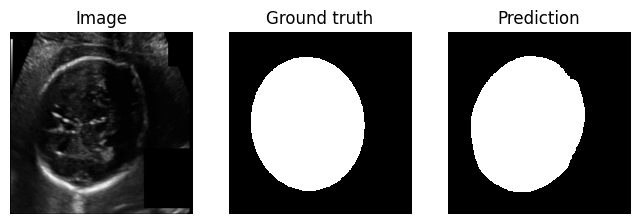

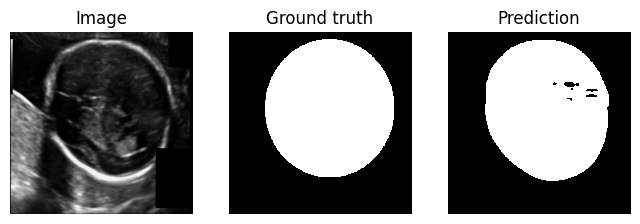

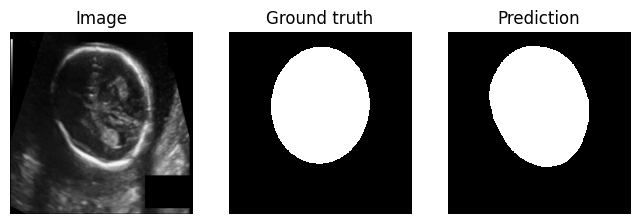

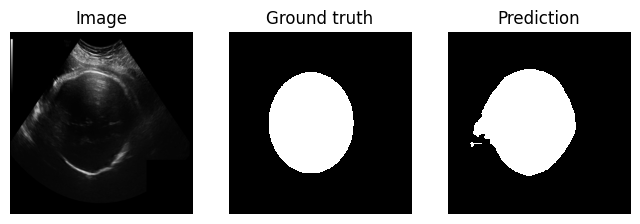

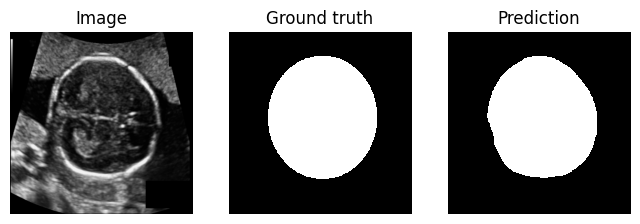

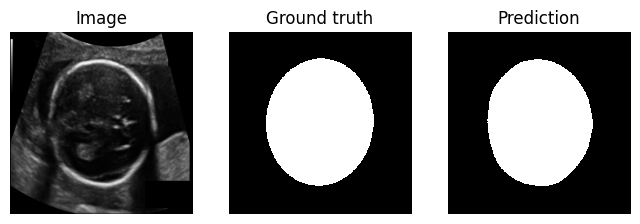

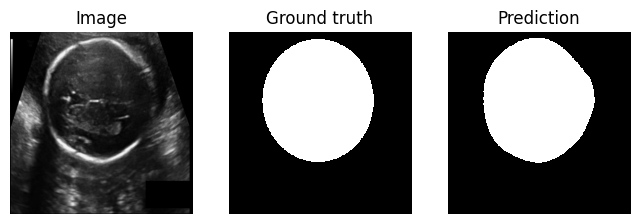

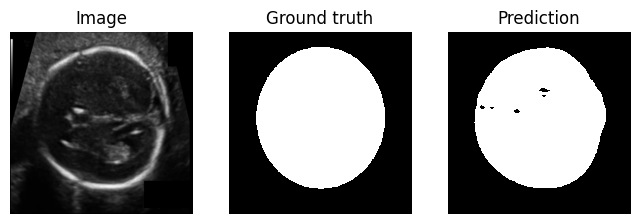

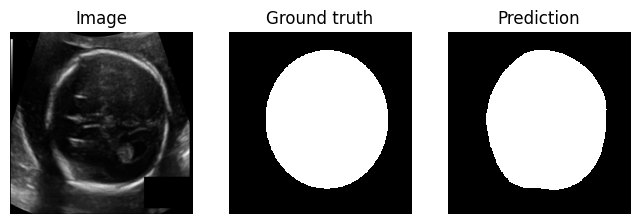

In [ ]:
with torch.no_grad():
  for x, y in testloader_subset:
    image = x.to(DEVICE)
    gt_mask = y.to(DEVICE).unsqueeze(1)
    preds = model(image)
    preds = preds[0]
    preds = (preds > 0.5).float()

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 3, 1)
    x = x.flatten(0, 1)
    plt.imshow(x.permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(1-y.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(1-preds.cpu().data.numpy().squeeze(),cmap='Greys',interpolation='nearest') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()